In [32]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D
from keras.models import Model, load_model
from sklearn.metrics import classification_report
from keras.optimizers import Adam

import cv2

import glob

In [33]:
# Set the path to the dataset directory
train_dir = './data/cats/train'
validation_dir = './data/cats/test'


In [34]:

# Set the image size and batch size
img_size = (224, 224)
num_classes=6
# define hyperparameters
batch_size = 32
num_of_hidden_units = 256
dropout_rate = 0.2


## Import data and create generators

In [35]:
# Create the train generator
# Create image data generator with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

# Create the validator generator
# Create image data generator without data augmentation for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 13648 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [84]:
def show_hist(generator):
  # Get the class labels for the training data
  class_labels = generator.classes

  # Count the number of instances of each class
  class_counts = np.bincount(class_labels)

  # Get the names of the classes from the directory iterator
  class_names = list(generator.class_indices.keys())

  # Create a bar chart of the class distribution
  fig, ax = plt.subplots()
  rects = ax.bar(class_names, class_counts)
  ax.set_title('Class Distribution in Training Data')
  ax.set_xlabel('Class')
  ax.set_ylabel('Count')

  # Add labels to each bar with the count
  for rect, count in zip(rects, class_counts):
      height = rect.get_height()
      ax.annotate(f'{count}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                  textcoords='offset points', ha='center', va='bottom')

  plt.show()

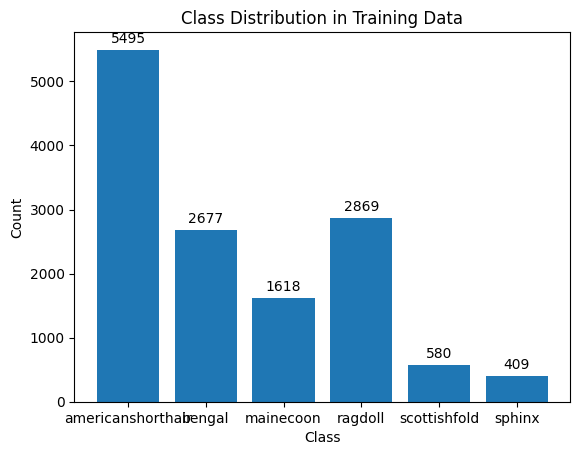

In [85]:
show_hist(train_generator)

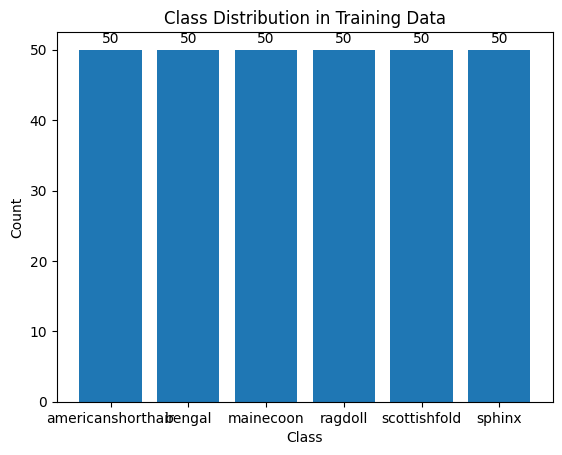

In [86]:
show_hist(validation_generator)

## Data Augmentation

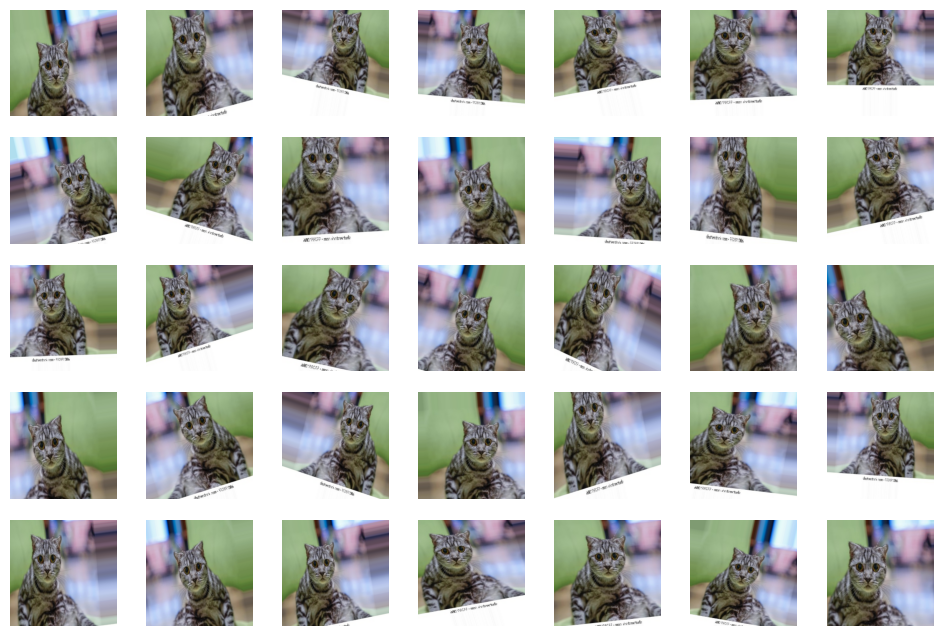

In [36]:
# iterator
img = load_img('./data/cats/train/americanshorthair/american-shorthair-cat-close-portrait-260nw-552851086.jpg', target_size=(256, 256))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# create data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# create iterator for the input data
it = datagen.flow(x, batch_size=1)

# generate and plot augmented images
fig = plt.figure(figsize=(12,8))
    
for i in range(35):
    ax = plt.subplot(5, 7, i+1)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')
plt.show()

fig.savefig('data_augmentation.png', dpi=fig.dpi)

## Sample images

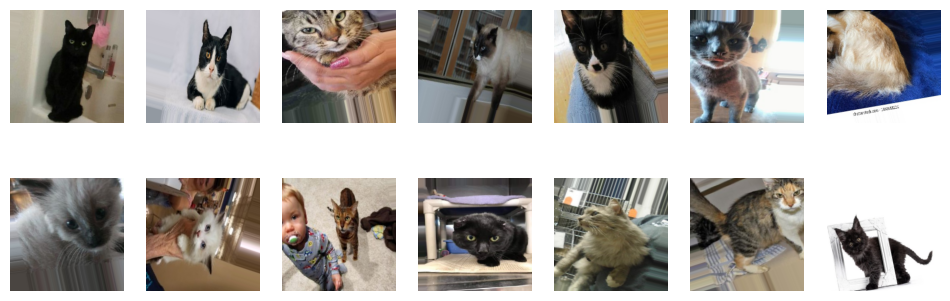

In [37]:
x_val_sample, _ = next(train_generator)
plt.figure(figsize=(12,4))

for i, x in enumerate(x_val_sample[:14]):
    ax = plt.subplot(2, 7, i+1)
    plt.imshow(x)
    plt.axis('off')
plt.show()

## Setup base model and layers

In [64]:
# input_layer = Input(shape=(224, 224, 3))
# x = Conv2D(128, (7, 7), padding='same', activation='relu', strides=(2, 2))(input_layer)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers in the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(inception_model.output)
x = Dense(num_of_hidden_units, activation='relu')(x)

# Add a dropout layer with a rate of 0.2 to the dense layer
x = Dropout(dropout_rate)(x)

# Add a final dense layer with the number of classes and a softmax activation
predictions = Dense(6, activation='softmax')(x) #I have 6 classes of image to classify

# Combine the base model and the top layers to create the final model
model = Model(inputs=inception_model.input, outputs=predictions)

# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 111, 111, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                           

/Users/korede/miniconda3/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 batch_normalization_439 (Batch  (None, 12, 12, 192)  576        ['conv2d_439[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_444 (Batch  (None, 12, 12, 192)  576        ['conv2d_444[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_445 (Batch  (None, 12, 12, 192)  576        ['conv2d_445[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

## Fit model

In [39]:

# Train the model for 10 epochs
num_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)
# Save the model
model.save('cat_breed_classification_model.h5')


Epoch 1/10
426/426 [==============================] - 158s 361ms/step - loss: 0.8922 - acc: 0.6745 - val_loss: 0.6331 - val_acc: 0.7361
Epoch 2/10
426/426 [==============================] - 162s 379ms/step - loss: 0.7472 - acc: 0.7219 - val_loss: 0.5059 - val_acc: 0.7847
Epoch 3/10
426/426 [==============================] - 202s 474ms/step - loss: 0.7212 - acc: 0.7357 - val_loss: 0.5482 - val_acc: 0.8299
Epoch 4/10
426/426 [==============================] - 176s 413ms/step - loss: 0.7080 - acc: 0.7359 - val_loss: 0.5013 - val_acc: 0.8125
Epoch 5/10
426/426 [==============================] - 170s 399ms/step - loss: 0.6854 - acc: 0.7450 - val_loss: 0.4506 - val_acc: 0.8576
Epoch 6/10
426/426 [==============================] - 156s 366ms/step - loss: 0.6752 - acc: 0.7481 - val_loss: 0.4040 - val_acc: 0.8681
Epoch 7/10
426/426 [==============================] - 158s 371ms/step - loss: 0.6585 - acc: 0.7568 - val_loss: 0.4470 - val_acc: 0.8229
Epoch 8/10
426/426 [============================

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [41]:
# model = load_model('cat_breed_classification_model.h5')

# Evaluate the model on the test data and get the metrics
predictions = model.predict(validation_generator)
target_names = list(validation_generator.class_indices.keys())
report = classification_report(validation_generator.classes, np.argmax(predictions, axis=1),
                               target_names=target_names, digits=4)

# Print the classification report
print(report)

10/10 [==============================] - 4s 269ms/step
                   precision    recall  f1-score   support

americanshorthair     0.1304    0.1200    0.1250        50
           bengal     0.1579    0.1800    0.1682        50
        mainecoon     0.2000    0.1200    0.1500        50
          ragdoll     0.1864    0.2200    0.2018        50
     scottishfold     0.2069    0.2400    0.2222        50
           sphinx     0.2400    0.2400    0.2400        50

         accuracy                         0.1867       300
        macro avg     0.1869    0.1867    0.1845       300
     weighted avg     0.1869    0.1867    0.1845       300



In [42]:
breed_names = {
    0: 'American Shorthair',
    1: 'Bengal',
    2: 'Maine Coon',
    3: 'Ragdoll',
    4: 'Scottish Fold',
    5: 'Sphynx'
}

## Plot the performance of the model

In [43]:

# datapoints = model.history.history

# history = {
#   'train_acc': ['Training accuracy', datapoints['accuracy']],
#   'test_acc': ['Validation accuracy', datapoints['val_accuracy']],
#   'train_loss': ['Training loss', datapoints['loss']],
#   'test_loss': ['Validation loss', datapoints['val_loss']]
# }




In [44]:
def plot_graph(history):
  title = 'Training/validation loss and accuracy'
  
  epochs = range(len(history['acc']))
  plt.title(title)
  plt.plot(epochs, history['acc'], label="Training accuracy")
  plt.plot(epochs, history['val_acc'], label="Validation accuracy")
  plt.plot(epochs, history['loss'], label="Training loss")
  plt.plot(epochs, history['val_loss'], label="Validation loss")
  plt.xlabel('epochs')
  plt.ylabel('accuracy or loss')
  plt.legend()
  plt.show()

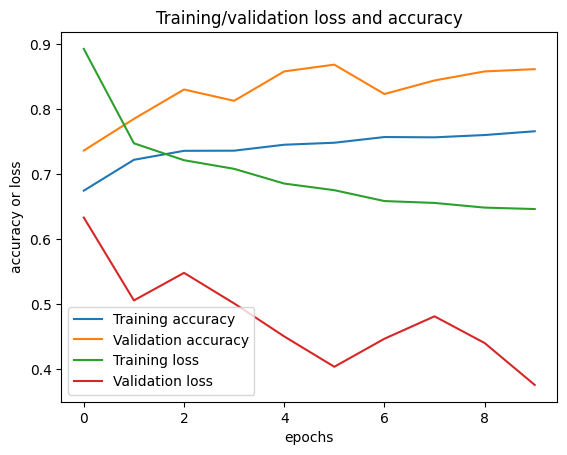

In [45]:
plot_graph(history.history)

## Evaluate the cat breed classification model

1/1 [==============================] - 1s 1s/step


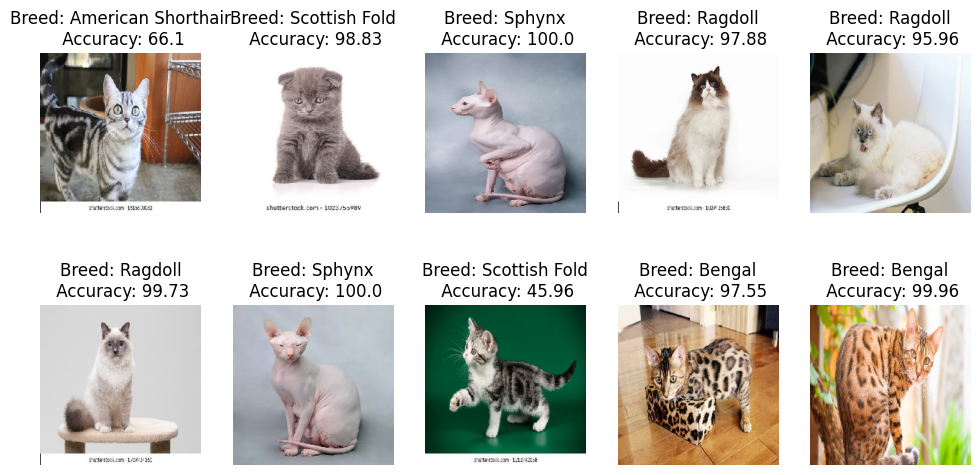

In [46]:
model = load_model('cat_breed_classification_model.h5')

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)
plt.figure(figsize=(12,6))


nb_sample = 10
for i, (x, y) in enumerate(zip(X_val_sample[:nb_sample], y_pred[:nb_sample])):
    ax = plt.subplot(2, 5, i+1)
    predicted_class = np.argmax(y)
    breed_name = breed_names[predicted_class]
    title = 'Breed: '+breed_name + '\n Accuracy: ' + str(round(np.max(y) * 100, 2))
    plt.imshow(x)
    plt.title(title)
    plt.axis('off')
plt.show()

## Algorithm to detect human face or cat breed

In [47]:
# import trained inceptionV3 model
model = load_model('cat_breed_classification_model.h5')
# import pretrained human face cascade
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

# preprocessing images
def tensor_3d_to_4d(img):
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(img, axis=0)

def detect_human_face(img):
  global face_cascade
  isHuman = False
  
  if (img is None): return isHuman
  
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  face = face_cascade.detectMultiScale(gray, 1.3, 5)

  for (x,y,w,h) in face:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
      isHuman = True

  return isHuman

def detect_cat_breed(img):
  global model
  y = model.predict(tensor_3d_to_4d(img))
  
  print(np.argmax(y))
  
  if (np.max(y) < 0.4): return False
  
  predicted_class = np.argmax(y)
  
  return [breed_names[predicted_class], round(np.max(y) * 100, 2)]
  
def eval_image(img):
  cat_breed = detect_cat_breed(img)
  
  print(cat_breed)
  
  if (detect_human_face(img)):
    return 'You\'re human\n'
  elif (cat_breed):
    return cat_breed[0] +' breed of cat\nI\'m '+ str(cat_breed[1]) +' sure'
  else:
    return 'Not human / cat\n'
  
  

## Test algorithm with human faces

1/1 [==============================] - 2s 2s/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 42ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 286ms/step
0
['American Shorthair', 99.79]
1/1 [==============================] - 0s 30ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 33ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 31ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 31ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 36ms/step
0
['American Shorthair', 90.38]
1/1 [==============================] - 0s 35ms/step
4
['Scottish Fold', 77.69]
1/1 [==============================] - 0s 86ms/step
0
['American Shorthair', 100.0]


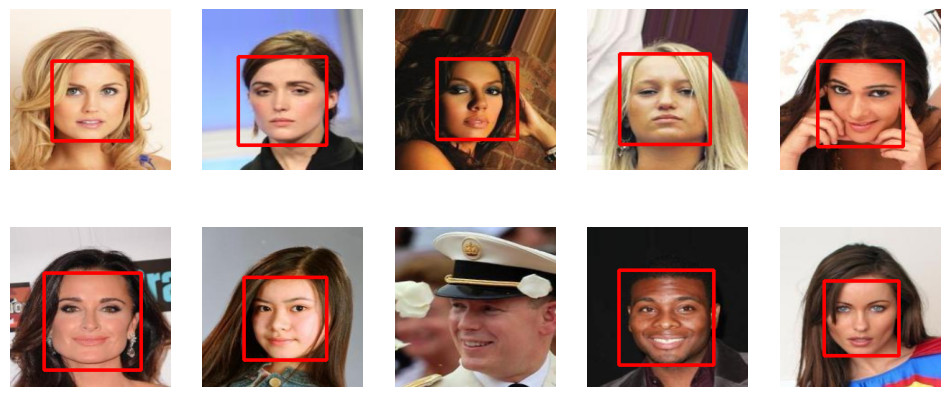

In [48]:
humans = [cv2.imread(file) for file in glob.glob("data/human/*.jpg")]

plt.figure(figsize=(12,8))

for i, image in enumerate(list(humans[0:10])):
  image = cv2.resize(image, (224, 224))
  ax = plt.subplot(3, 5, i+1)
  title = eval_image(image)

  cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(cv_rgb)
  # plt.title(title)
  plt.axis("off")
plt.show()

## Test the Algorithm

1/1 [==============================] - 0s 31ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 30ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 31ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 30ms/step
1
['Bengal', 99.08]
1/1 [==============================] - 0s 30ms/step
1
['Bengal', 93.7]
1/1 [==============================] - 0s 29ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 30ms/step
1
['Bengal', 82.77]
1/1 [==============================] - 0s 31ms/step
4
['Scottish Fold', 100.0]
1/1 [==============================] - 0s 31ms/step
0
['American Shorthair', 99.26]
1/1 [==============================] - 0s 29ms/step
0
['American Shorthair', 100.0]


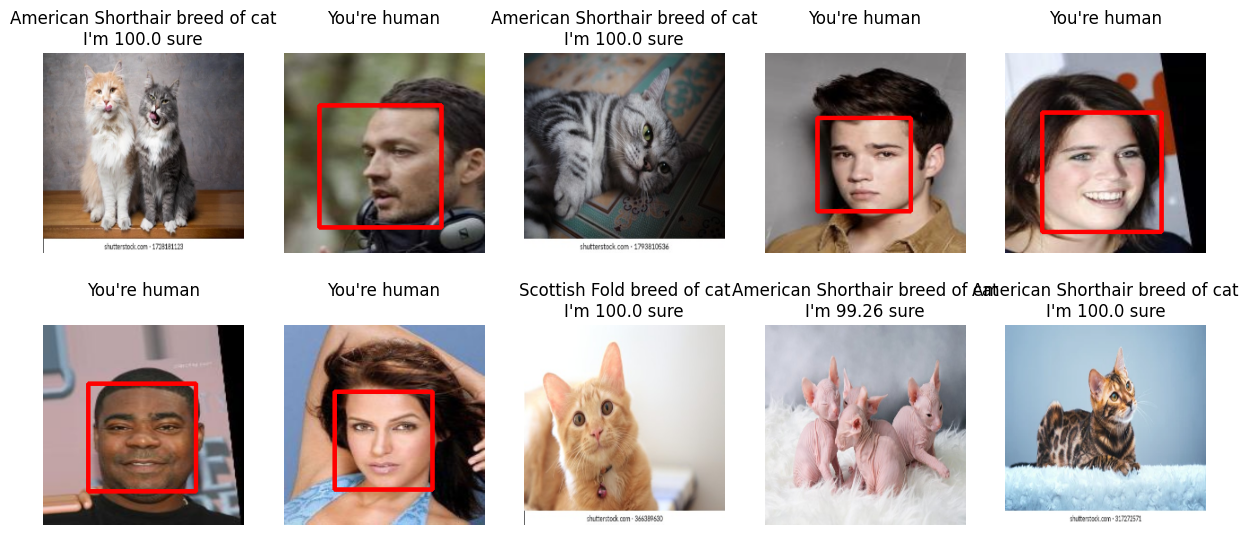

In [49]:
catshumans = [cv2.imread(file) for file in glob.glob("./data/cathuman/*.jpg")]

plt.figure(figsize=(15,10))

for i, image in enumerate(catshumans):
  if (image is None): continue
  
  image = cv2.resize(image, (224, 224))
  ax = plt.subplot(3, 5, i+1)
  
  title = eval_image(image)
  cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(cv_rgb)
  plt.title(title)
  plt.axis("off")
plt.show()

1/1 [==============================] - 2s 2s/step
0
['American Shorthair', 93.86]
1/1 [==============================] - 1s 754ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 0s 231ms/step
0
['American Shorthair', 95.14]
1/1 [==============================] - 2s 2s/step
4
['Scottish Fold', 100.0]
1/1 [==============================] - 0s 296ms/step
0
['American Shorthair', 100.0]
1/1 [==============================] - 1s 1s/step
0
['American Shorthair', 99.99]
1/1 [==============================] - 0s 326ms/step
4
['Scottish Fold', 98.07]
1/1 [==============================] - 0s 478ms/step
0
['American Shorthair', 99.97]
1/1 [==============================] - 0s 487ms/step
0
['American Shorthair', 96.27]
1/1 [==============================] - 0s 38ms/step
4
['Scottish Fold', 100.0]


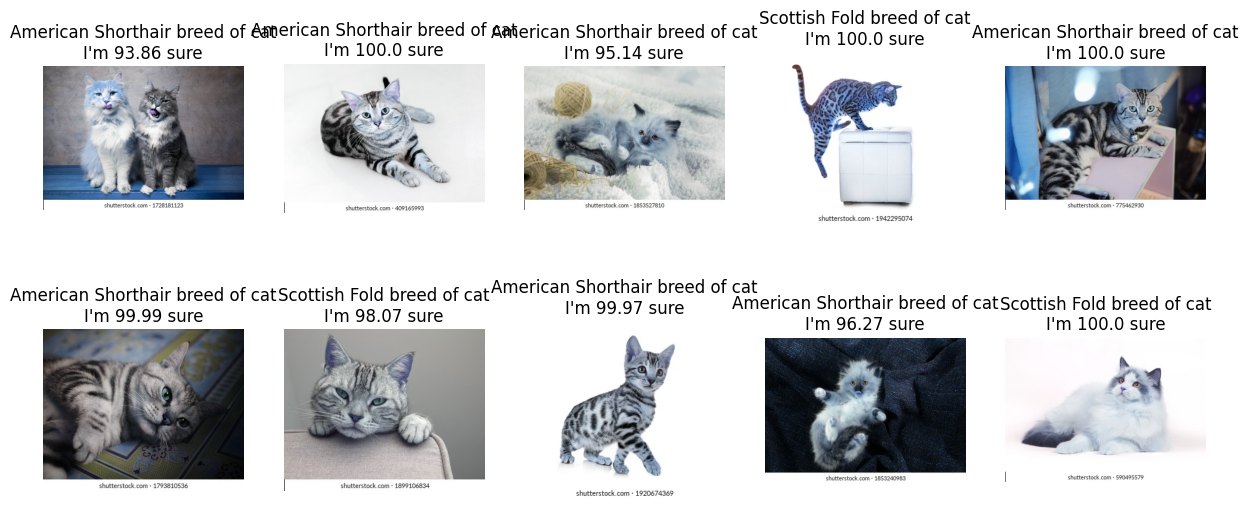

In [50]:
cats = [cv2.imread(file) for file in glob.glob("./data/different_cat_breeds/*.jpg")]

plt.figure(figsize=(15,10))

for i, image in enumerate(cats[:10]):
  if (image is None): continue
  
  ax = plt.subplot(3, 5, i+1)
  
  title = eval_image(image)
  cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
plt.show()

## Comparison with other Optimizers

In [65]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers in the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(inception_model.output)
x = Dense(num_of_hidden_units, activation='relu')(x)

# Add a dropout layer with a rate of 0.2 to the dense layer
# x = Dropout(dropout_rate)(x)

# Add a final dense layer with the number of classes and a softmax activation
predictions = Dense(6, activation='softmax')(x) #I have 6 classes of image to classify

# Combine the base model and the top layers to create the final model
model_other_optim = Model(inputs=inception_model.input, outputs=predictions)

# Define optimizers
optimizers = ['sgd', 'rmsprop', 'adagrad']
# optimizers = ['sgd']
optimizers_hist = {}

# Train model with each optimizer
for optimizer in optimizers:
    # Compile model with optimizer
    model_other_optim.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    # Train the model for 10 epochs
    num_epochs = 10

    optimizers_hist[optimizer] = model_other_optim.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // batch_size)
    # Save the model
    model_other_optim.save('cat_breed_classification_model_'+ optimizer +'.h5')


Epoch 1/10
426/426 [==============================] - 134s 303ms/step - loss: 0.9181 - acc: 0.6616 - val_loss: 0.7260 - val_acc: 0.7083
Epoch 2/10
426/426 [==============================] - 97s 228ms/step - loss: 0.7532 - acc: 0.7236 - val_loss: 0.5853 - val_acc: 0.7812
Epoch 3/10
426/426 [==============================] - 101s 237ms/step - loss: 0.7115 - acc: 0.7409 - val_loss: 0.5289 - val_acc: 0.8021
Epoch 4/10
426/426 [==============================] - 97s 227ms/step - loss: 0.6960 - acc: 0.7460 - val_loss: 0.5163 - val_acc: 0.7951
Epoch 5/10
426/426 [==============================] - 97s 228ms/step - loss: 0.6856 - acc: 0.7470 - val_loss: 0.4573 - val_acc: 0.8438
Epoch 6/10
426/426 [==============================] - 107s 251ms/step - loss: 0.6699 - acc: 0.7548 - val_loss: 0.4548 - val_acc: 0.8368
Epoch 7/10
426/426 [==============================] - 105s 245ms/step - loss: 0.6591 - acc: 0.7557 - val_loss: 0.4582 - val_acc: 0.8333
Epoch 8/10
426/426 [==============================]

In [66]:
optimizers_hist['adam'] = history

In [67]:
optimizers_hist

{'sgd': <keras.callbacks.History at 0x2d3528c70>,
 'rmsprop': <keras.callbacks.History at 0x57a55e170>,
 'adagrad': <keras.callbacks.History at 0x2e51609d0>,
 'adam': <keras.callbacks.History at 0x299cdb730>}

In [68]:
import pandas as pd

In [76]:
data_dict = {}
for key, value in optimizers_hist.items():
    for k, v in value.history.items():
        data_dict.setdefault(k, {})[key] = np.mean(v)

# Create the DataFrame from the dictionary
df = pd.DataFrame(data=data_dict)

df = df[['acc', 'val_acc']]

df

acc   val_acc
sgd      0.742641  0.812500
rmsprop  0.738653  0.835069
adagrad  0.789204  0.888889
adam     0.739990  0.827431

In [70]:
print(df.to_numpy())

[[0.70067817 0.742641   0.507412   0.8125    ]
 [0.72513663 0.73865304 0.46174528 0.83506945]
 [0.56732631 0.78920386 0.35063999 0.8888889 ]
 [0.70379499 0.7399897  0.47880085 0.82743056]]


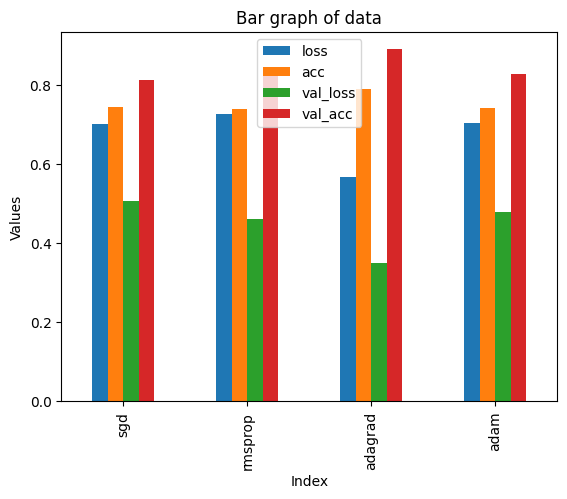

In [71]:
df.plot(kind='bar')
plt.title('Bar graph of data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

In [72]:

optimizers_str = ['', '_sgd', '_rmsprop', '_adagrad']
models = {}

for opt in optimizers_str:
  models[opt] = load_model('cat_breed_classification_model'+ opt +'.h5')
  
  predictions = models[opt].predict(validation_generator)
  target_names = list(validation_generator.class_indices.keys())
  report = classification_report(validation_generator.classes, np.argmax(predictions, axis=1),
                               target_names=target_names, digits=4)
  
  print(opt)
  print(report)

10/10 [==============================] - 8s 365ms/step

                   precision    recall  f1-score   support

americanshorthair     0.2391    0.2200    0.2292        50
           bengal     0.1930    0.2200    0.2056        50
        mainecoon     0.2667    0.1600    0.2000        50
          ragdoll     0.1695    0.2000    0.1835        50
     scottishfold     0.1724    0.2000    0.1852        50
           sphinx     0.0800    0.0800    0.0800        50

         accuracy                         0.1800       300
        macro avg     0.1868    0.1800    0.1806       300
     weighted avg     0.1868    0.1800    0.1806       300

10/10 [==============================] - 5s 342ms/step
_sgd
                   precision    recall  f1-score   support

americanshorthair     0.1385    0.1800    0.1565        50
           bengal     0.0612    0.0600    0.0606        50
        mainecoon     0.2121    0.1400    0.1687        50
          ragdoll     0.1833    0.2200    0.2000      

In [73]:
# Evaluate the model on the test data and get the metrics
predictions = model.predict(validation_generator)
target_names = list(validation_generator.class_indices.keys())
report = classification_report(validation_generator.classes, np.argmax(predictions, axis=1),
                               target_names=target_names, digits=4)

# Print the classification report
print(report)

10/10 [==============================] - 10s 464ms/step
                   precision    recall  f1-score   support

americanshorthair     0.1053    0.1600    0.1270        50
           bengal     0.2063    0.2600    0.2301        50
        mainecoon     0.1154    0.0600    0.0789        50
          ragdoll     0.0833    0.0200    0.0323        50
     scottishfold     0.1414    0.2800    0.1879        50
           sphinx     0.3333    0.1600    0.2162        50

         accuracy                         0.1567       300
        macro avg     0.1642    0.1567    0.1454       300
     weighted avg     0.1642    0.1567    0.1454       300

